# 🚀 XGBoost Regression: DAT Binding Prediction

**Goal**: Predict pKi values (binding strength) using XGBoost with train/test split

**Dataset**: 541 compounds with RDKit descriptors  
**Target**: pKi (continuous variable)  
**Method**: XGBoost Regression + 80/20 Train/Test Split + Early Stopping

**Key Differences from Random Forest:**
- Uses gradient boosting (sequential trees) instead of bagging
- 80/20 split for proper test set evaluation
- Early stopping to prevent overfitting
- More hyperparameters to tune

---


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import randint, uniform

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 📂 Step 1: Load Processed Data from Analysis

**Source:** `processed_DAT_rdkit_features.csv` (from dataanalyse.ipynb)

This ensures we use the **same RDKit features** across all models!


In [2]:
# Load processed RDKit features from data analysis
df_rdkit = pd.read_csv('saved_models/processed_DAT_rdkit_features.csv')

print("="*60)
print("📂 LOADED PROCESSED DATA FROM ANALYSIS")
print("="*60)
print(f"✅ Dataset: {len(df_rdkit)} compounds")
print(f"✅ Features: {len(df_rdkit.columns)-2} RDKit descriptors")
print(f"✅ Source: dataanalyse.ipynb (same features as other models!)")
print(f"\n📊 pKi distribution:")
print(f"   Min: {df_rdkit['pKi'].min():.2f}")
print(f"   Max: {df_rdkit['pKi'].max():.2f}")
print(f"   Mean: {df_rdkit['pKi'].mean():.2f}")
print(f"   Median: {df_rdkit['pKi'].median():.2f}")
print("\n🔬 Available features:")
print([col for col in df_rdkit.columns if col not in ['ChEMBL_ID', 'pKi']])
print("="*60)
print(df_rdkit.head())


📂 LOADED PROCESSED DATA FROM ANALYSIS
✅ Dataset: 541 compounds
✅ Features: 17 RDKit descriptors
✅ Source: dataanalyse.ipynb (same features as other models!)

📊 pKi distribution:
   Min: 3.41
   Max: 10.40
   Mean: 6.92
   Median: 6.95

🔬 Available features:
['MolWt', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotatableBonds', 'AromaticRings', 'HeavyAtoms', 'NumRings', 'NumSaturatedRings', 'NumAliphaticRings', 'MolMR', 'NumCarbons', 'NumNitrogens', 'NumOxygens', 'NumFluorines', 'NumHalogens']
     ChEMBL_ID   pKi    MolWt     LogP   TPSA  HBD  HBA  RotatableBonds  \
0    CHEMBL549  4.78  324.399  3.81298  36.26    0    3               5   
1    CHEMBL607  4.75  247.338  2.21310  29.54    0    3               3   
2    CHEMBL904  7.13  233.311  2.08530  38.33    1    3               3   
3   CHEMBL1708  7.01  329.371  3.32650  39.72    1    4               4   
4  CHEMBL11493  7.98  385.498  5.86630  12.47    0    2               7   

   AromaticRings  HeavyAtoms  NumRings  NumSaturatedRings  NumAl

## 🔧 Step 2: Prepare Features & Split Data (80/20)

**Key Difference from RF:** We use an 80/20 train/test split instead of cross-validation only.

This allows:
- Proper held-out test set evaluation
- Early stopping monitoring
- Fair comparison with Neural Networks


In [3]:
# Separate features and target
X = df_rdkit.drop(['ChEMBL_ID', 'pKi'], axis=1)
y = df_rdkit['pKi']

print("="*60)
print("🔧 FEATURE PREPARATION")
print("="*60)
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nFeature names: {list(X.columns)}")
print("="*60)


🔧 FEATURE PREPARATION
Features (X): (541, 17)
Target (y): (541,)

Feature names: ['MolWt', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotatableBonds', 'AromaticRings', 'HeavyAtoms', 'NumRings', 'NumSaturatedRings', 'NumAliphaticRings', 'MolMR', 'NumCarbons', 'NumNitrogens', 'NumOxygens', 'NumFluorines', 'NumHalogens']


In [4]:
# 80/20 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("="*60)
print("📊 TRAIN-TEST SPLIT (80/20)")
print("="*60)
print(f"Training set: {X_train.shape[0]} compounds ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} compounds ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining pKi range: {y_train.min():.2f} - {y_train.max():.2f}")
print(f"Test pKi range: {y_test.min():.2f} - {y_test.max():.2f}")
print("="*60)


📊 TRAIN-TEST SPLIT (80/20)
Training set: 432 compounds (79.9%)
Test set: 109 compounds (20.1%)

Training pKi range: 3.41 - 10.40
Test pKi range: 4.66 - 9.28


In [5]:
# Scale features (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print(f"   Training set scaled: {X_train_scaled.shape}")
print(f"   Test set scaled: {X_test_scaled.shape}")


✅ Features scaled using StandardScaler
   Training set scaled: (432, 17)
   Test set scaled: (109, 17)


## 🎯 Step 3: Train Baseline XGBoost Model

**Baseline Configuration:**
- `n_estimators=1000` (will use early stopping)
- `learning_rate=0.1` (default)
- `max_depth=6` (default)
- Early stopping with 50 rounds patience


In [6]:
# Initialize baseline XGBoost model
xgb_baseline = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50  # Early stopping as model parameter
)

print("🚀 Training Baseline XGBoost Model with Early Stopping...")
print("   This may take a minute...\n")

# Train with evaluation set
xgb_baseline.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

print(f"✅ Training completed!")
print(f"   Best iteration: {xgb_baseline.best_iteration}")
print(f"   Total trees trained: {xgb_baseline.n_estimators}")


🚀 Training Baseline XGBoost Model with Early Stopping...
   This may take a minute...

✅ Training completed!
   Best iteration: 20
   Total trees trained: 1000


## 📊 Step 4: Evaluate Baseline Model


In [7]:
# Predictions on training set
y_train_pred = xgb_baseline.predict(X_train_scaled)

# Predictions on test set
y_test_pred = xgb_baseline.predict(X_test_scaled)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("="*70)
print("📊 BASELINE XGBOOST MODEL PERFORMANCE")
print("="*70)
print(f"\n{'Metric':<20} {'Training Set':<20} {'Test Set':<20}")
print("-"*70)
print(f"{'R² Score':<20} {train_r2:<20.4f} {test_r2:<20.4f}")
print(f"{'RMSE':<20} {train_rmse:<20.4f} {test_rmse:<20.4f}")
print(f"{'MAE':<20} {train_mae:<20.4f} {test_mae:<20.4f}")
print("-"*70)

# Check for overfitting
overfit_r2 = train_r2 - test_r2
print(f"\n🔍 Overfitting Analysis:")
print(f"   R² difference (train - test): {overfit_r2:.4f}")
if overfit_r2 > 0.1:
    print(f"   ⚠️  Potential overfitting detected!")
elif overfit_r2 > 0.05:
    print(f"   ⚡ Mild overfitting")
else:
    print(f"   ✅ Good generalization!")
print("="*70)


📊 BASELINE XGBOOST MODEL PERFORMANCE

Metric               Training Set         Test Set            
----------------------------------------------------------------------
R² Score             0.8330               0.5830              
RMSE                 0.4785               0.7352              
MAE                  0.3802               0.5491              
----------------------------------------------------------------------

🔍 Overfitting Analysis:
   R² difference (train - test): 0.2500
   ⚠️  Potential overfitting detected!


## 📈 Step 5: Visualize Predictions


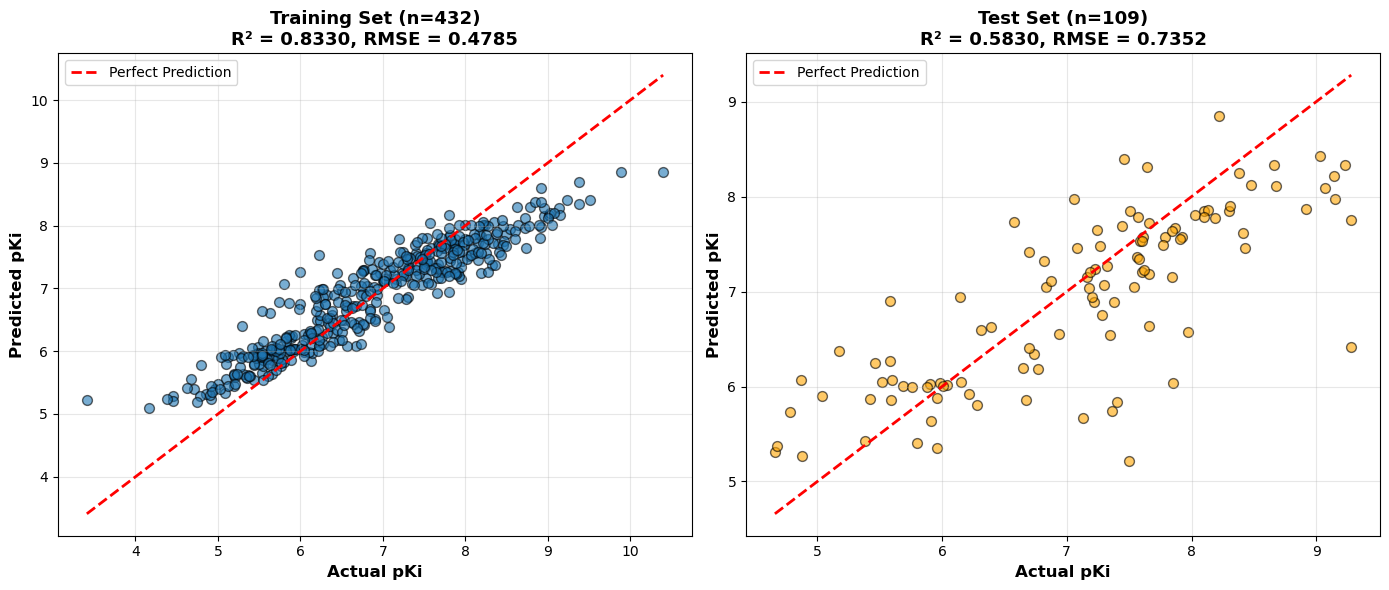

In [8]:
# Actual vs Predicted plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6, edgecolors='black', s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set (n={len(y_train)})\nR² = {train_r2:.4f}, RMSE = {train_rmse:.4f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='black', s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set (n={len(y_test)})\nR² = {test_r2:.4f}, RMSE = {test_rmse:.4f}', 
                  fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


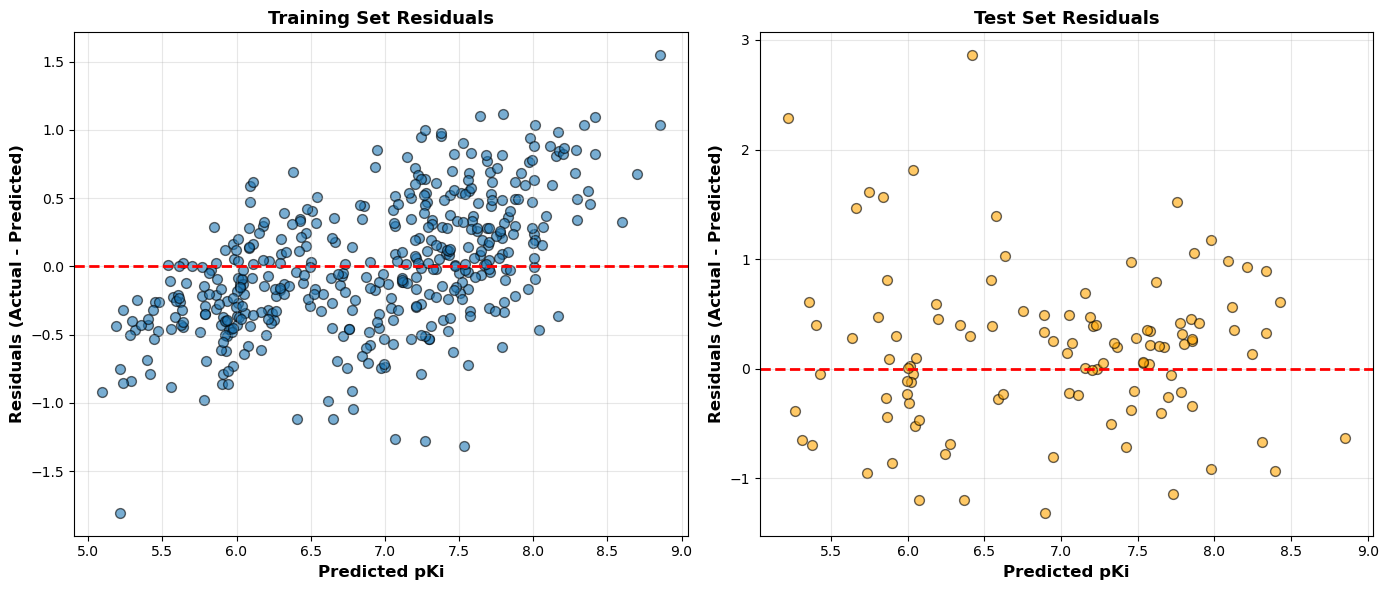

In [9]:
# Residual plots
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training residuals
axes[0].scatter(y_train_pred, train_residuals, alpha=0.6, edgecolors='black', s=50)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[0].set_title('Training Set Residuals', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Test residuals
axes[1].scatter(y_test_pred, test_residuals, alpha=0.6, edgecolors='black', s=50, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[1].set_title('Test Set Residuals', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 🎯 Step 6: Feature Importance Analysis


🎯 FEATURE IMPORTANCE (Baseline XGBoost)
          Feature  Importance
         NumRings    0.347024
NumAliphaticRings    0.154658
NumSaturatedRings    0.134549
     NumFluorines    0.061643
    AromaticRings    0.036168
   RotatableBonds    0.034583
       NumOxygens    0.030042
             TPSA    0.028067
     NumNitrogens    0.025651
             LogP    0.023495
            MolMR    0.022326
       NumCarbons    0.021787
              HBA    0.020013
              HBD    0.019396
       HeavyAtoms    0.015511
      NumHalogens    0.014824
            MolWt    0.010262


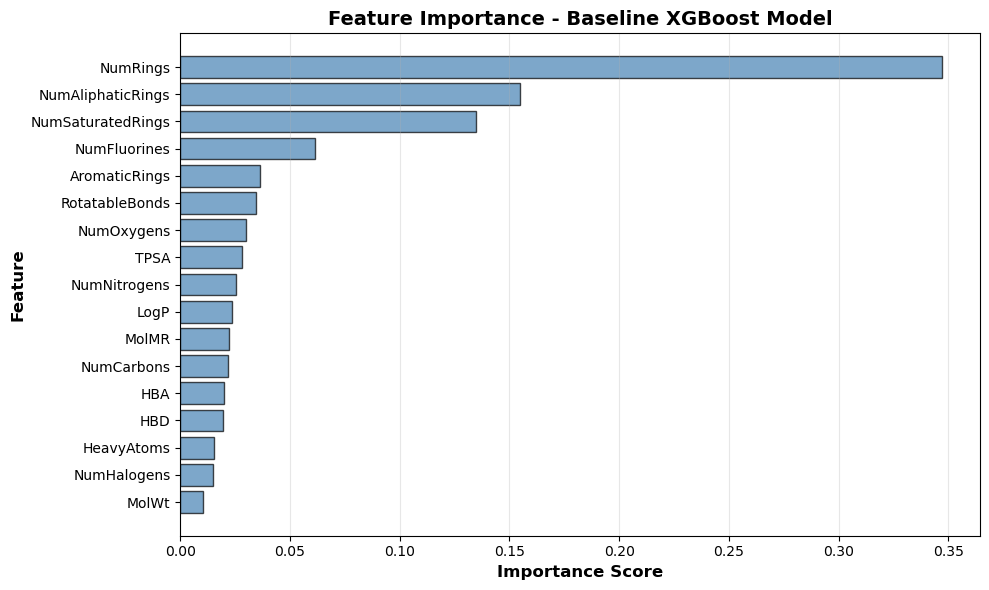

In [10]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_baseline.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*60)
print("🎯 FEATURE IMPORTANCE (Baseline XGBoost)")
print("="*60)
print(feature_importance.to_string(index=False))
print("="*60)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
         color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Feature Importance - Baseline XGBoost Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 🔧 Step 7: Hyperparameter Tuning with RandomizedSearchCV

**Strategy:** Use RandomizedSearch to find optimal hyperparameters

**Key Parameters to Tune:**
- `n_estimators`: Number of boosting rounds
- `learning_rate`: Step size for updates
- `max_depth`: Tree complexity
- `subsample`: Row sampling
- `colsample_bytree`: Column sampling
- `gamma`: Minimum loss reduction for split
- `reg_alpha`: L1 regularization
- `reg_lambda`: L2 regularization


In [11]:
# Define parameter distributions
param_distributions = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2)
}

# Initialize XGBoost for tuning
xgb_tuning = XGBRegressor(random_state=42, n_jobs=-1)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_tuning,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("="*70)
print("🔍 HYPERPARAMETER TUNING - RANDOMIZED SEARCH")
print("="*70)
print(f"Total iterations: 100")
print(f"Cross-validation: 5-fold")
print(f"Scoring metric: R²")
print(f"\n🚀 Starting search... (this will take several minutes)\n")

# Fit
random_search.fit(X_train_scaled, y_train)

print("\n" + "="*70)
print("✅ HYPERPARAMETER TUNING COMPLETED!")
print("="*70)
print(f"\n🏆 Best Parameters:")
for param, value in random_search.best_params_.items():
    print(f"   {param:<20s}: {value}")
print(f"\n🎯 Best Cross-Validation R² Score: {random_search.best_score_:.4f}")
print("="*70)


🔍 HYPERPARAMETER TUNING - RANDOMIZED SEARCH
Total iterations: 100
Cross-validation: 5-fold
Scoring metric: R²

🚀 Starting search... (this will take several minutes)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

✅ HYPERPARAMETER TUNING COMPLETED!

🏆 Best Parameters:
   colsample_bytree    : 0.8430179407605753
   gamma               : 0.08526206184364576
   learning_rate       : 0.029515477895583855
   max_depth           : 6
   min_child_weight    : 1
   n_estimators        : 415
   reg_alpha           : 0.5632882178455393
   reg_lambda          : 0.7708330050798322
   subsample           : 0.6063865008880857

🎯 Best Cross-Validation R² Score: 0.5931


In [12]:
# Get best model
best_xgb_model = random_search.best_estimator_

# Evaluate tuned model
y_train_pred_tuned = best_xgb_model.predict(X_train_scaled)
y_test_pred_tuned = best_xgb_model.predict(X_test_scaled)

# Calculate metrics
train_r2_tuned = r2_score(y_train, y_train_pred_tuned)
train_rmse_tuned = np.sqrt(mean_squared_error(y_train, y_train_pred_tuned))
train_mae_tuned = mean_absolute_error(y_train, y_train_pred_tuned)

test_r2_tuned = r2_score(y_test, y_test_pred_tuned)
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)

print("="*70)
print("📊 TUNED XGBOOST MODEL PERFORMANCE")
print("="*70)
print(f"\n{'Metric':<20} {'Training Set':<20} {'Test Set':<20}")
print("-"*70)
print(f"{'R² Score':<20} {train_r2_tuned:<20.4f} {test_r2_tuned:<20.4f}")
print(f"{'RMSE':<20} {train_rmse_tuned:<20.4f} {test_rmse_tuned:<20.4f}")
print(f"{'MAE':<20} {train_mae_tuned:<20.4f} {test_mae_tuned:<20.4f}")
print("-"*70)

# Check for overfitting
overfit_r2_tuned = train_r2_tuned - test_r2_tuned
print(f"\n🔍 Overfitting Analysis:")
print(f"   R² difference (train - test): {overfit_r2_tuned:.4f}")
if overfit_r2_tuned > 0.1:
    print(f"   ⚠️  Potential overfitting detected!")
elif overfit_r2_tuned > 0.05:
    print(f"   ⚡ Mild overfitting")
else:
    print(f"   ✅ Good generalization!")
print("="*70)


📊 TUNED XGBOOST MODEL PERFORMANCE

Metric               Training Set         Test Set            
----------------------------------------------------------------------
R² Score             0.9454               0.5797              
RMSE                 0.2737               0.7381              
MAE                  0.2074               0.5235              
----------------------------------------------------------------------

🔍 Overfitting Analysis:
   R² difference (train - test): 0.3657
   ⚠️  Potential overfitting detected!


## 📈 Step 7.5: Tuned Model Visualizations

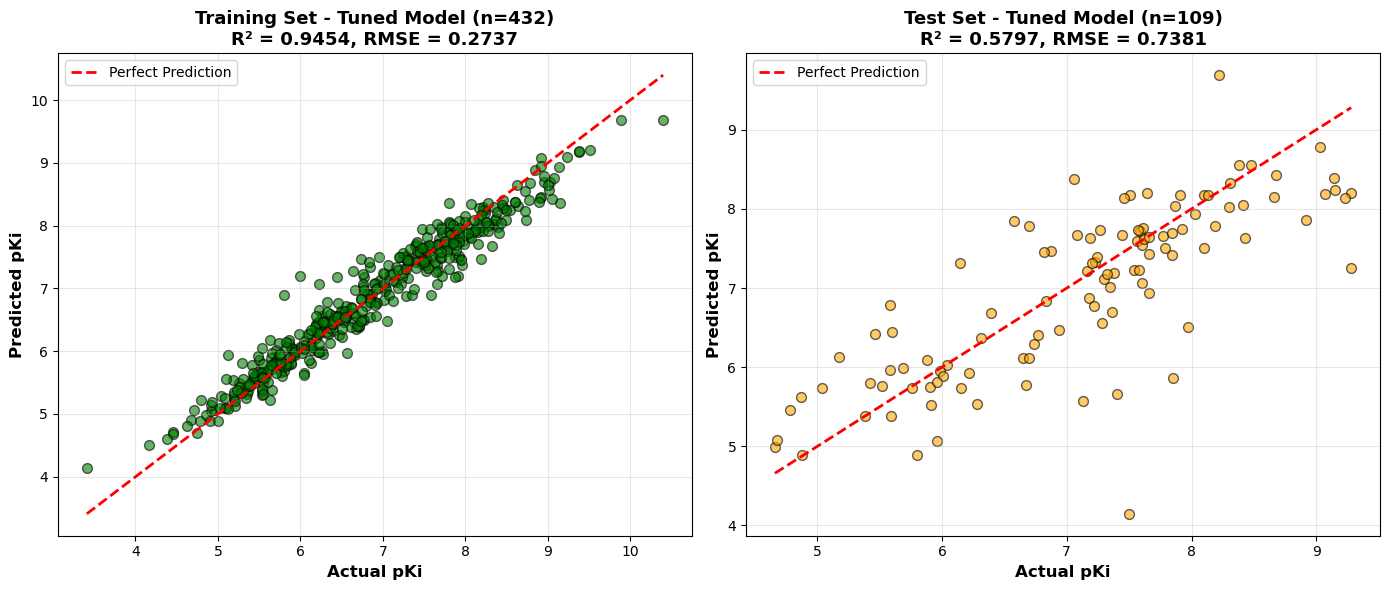

In [13]:
# Actual vs Predicted plots for Tuned Model
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_tuned, alpha=0.6, edgecolors='black', s=50, color='green')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set - Tuned Model (n={len(y_train)})\nR² = {train_r2_tuned:.4f}, RMSE = {train_rmse_tuned:.4f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_tuned, alpha=0.6, edgecolors='black', s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual pKi', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted pKi', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set - Tuned Model (n={len(y_test)})\nR² = {test_r2_tuned:.4f}, RMSE = {test_rmse_tuned:.4f}', 
                  fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 Step 8: Compare Baseline vs Tuned Model


In [14]:
# Comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline XGBoost', 'Tuned XGBoost'],
    'Train R²': [train_r2, train_r2_tuned],
    'Test R²': [test_r2, test_r2_tuned],
    'Train RMSE': [train_rmse, train_rmse_tuned],
    'Test RMSE': [test_rmse, test_rmse_tuned],
    'Train MAE': [train_mae, train_mae_tuned],
    'Test MAE': [test_mae, test_mae_tuned]
})

print("="*80)
print("📊 MODEL COMPARISON: Baseline vs Tuned")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Calculate improvements
r2_improvement = (test_r2_tuned - test_r2) / abs(test_r2) * 100 if test_r2 != 0 else 0
rmse_improvement = (test_rmse - test_rmse_tuned) / test_rmse * 100 if test_rmse != 0 else 0
mae_improvement = (test_mae - test_mae_tuned) / test_mae * 100 if test_mae != 0 else 0

print(f"\n✨ Improvements on Test Set:")
print(f"   R² improvement: {r2_improvement:+.2f}%")
print(f"   RMSE improvement: {rmse_improvement:+.2f}%")
print(f"   MAE improvement: {mae_improvement:+.2f}%")
print("="*80)


📊 MODEL COMPARISON: Baseline vs Tuned
           Model  Train R²  Test R²  Train RMSE  Test RMSE  Train MAE  Test MAE
Baseline XGBoost  0.833013 0.583007    0.478545   0.735190   0.380201  0.549063
   Tuned XGBoost  0.945391 0.579728    0.273661   0.738075   0.207437  0.523496

✨ Improvements on Test Set:
   R² improvement: -0.56%
   RMSE improvement: -0.39%
   MAE improvement: +4.66%


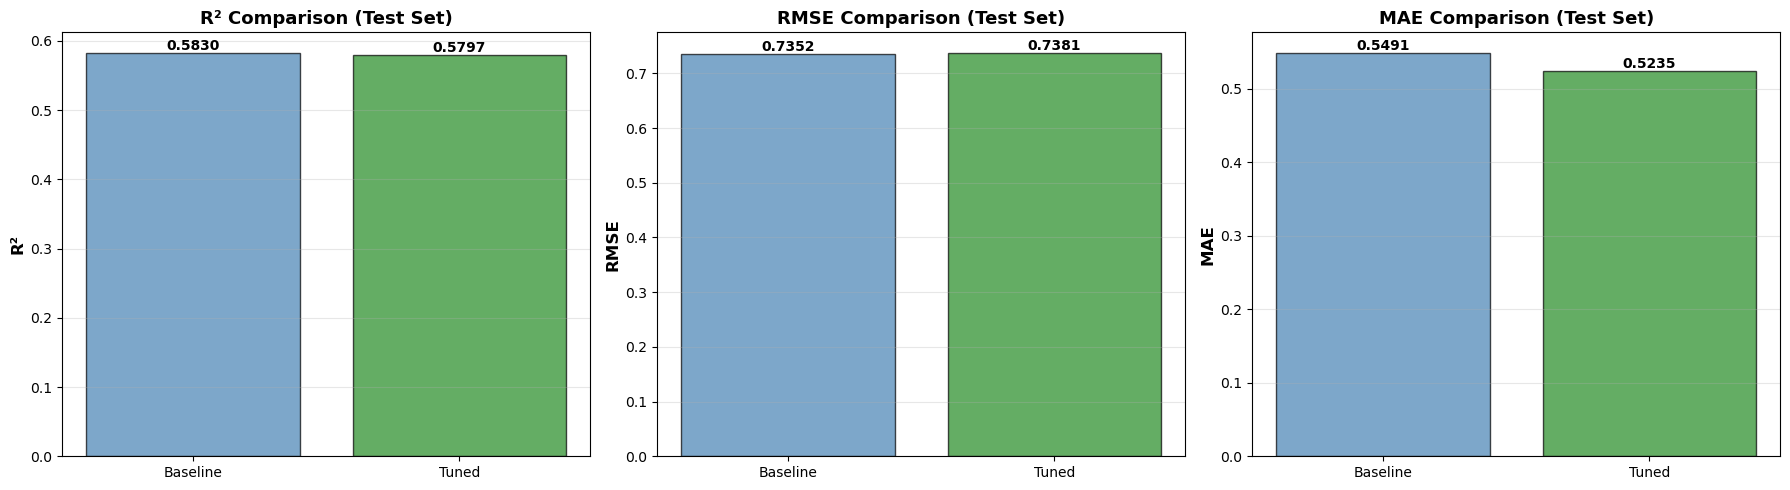

In [15]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['R²', 'RMSE', 'MAE']
baseline_vals = [test_r2, test_rmse, test_mae]
tuned_vals = [test_r2_tuned, test_rmse_tuned, test_mae_tuned]

for i, (metric, baseline, tuned) in enumerate(zip(metrics, baseline_vals, tuned_vals)):
    x = ['Baseline', 'Tuned']
    y = [baseline, tuned]
    colors = ['steelblue', 'forestgreen']
    
    bars = axes[i].bar(x, y, color=colors, edgecolor='black', alpha=0.7)
    axes[i].set_ylabel(metric, fontsize=12, fontweight='bold')
    axes[i].set_title(f'{metric} Comparison (Test Set)', fontsize=13, fontweight='bold')
    axes[i].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## 🎯 Step 9: Classification Performance (Confusion Matrix)

Convert continuous predictions to categories:
- **Low**: pKi < 6.0
- **Medium**: 6.0 ≤ pKi < 8.0
- **High**: pKi ≥ 8.0


In [16]:
# Define classification function
def classify_pKi(pKi_values):
    """Convert continuous pKi to categories"""
    categories = []
    for pKi in pKi_values:
        if pKi < 6.0:
            categories.append('Low')
        elif pKi < 8.0:
            categories.append('Medium')
        else:
            categories.append('High')
    return np.array(categories)

# Convert to categories (test set only)
y_test_categorical = classify_pKi(y_test)
y_test_pred_baseline_cat = classify_pKi(y_test_pred)
y_test_pred_tuned_cat = classify_pKi(y_test_pred_tuned)

print("="*60)
print("📊 TEST SET CLASSIFICATION DISTRIBUTION")
print("="*60)
print(f"Low Binders (pKi < 6.0): {np.sum(y_test_categorical == 'Low')} compounds")
print(f"Medium Binders (6.0 ≤ pKi < 8.0): {np.sum(y_test_categorical == 'Medium')} compounds")
print(f"High Binders (pKi ≥ 8.0): {np.sum(y_test_categorical == 'High')} compounds")
print("="*60)


📊 TEST SET CLASSIFICATION DISTRIBUTION
Low Binders (pKi < 6.0): 24 compounds
Medium Binders (6.0 ≤ pKi < 8.0): 63 compounds
High Binders (pKi ≥ 8.0): 22 compounds


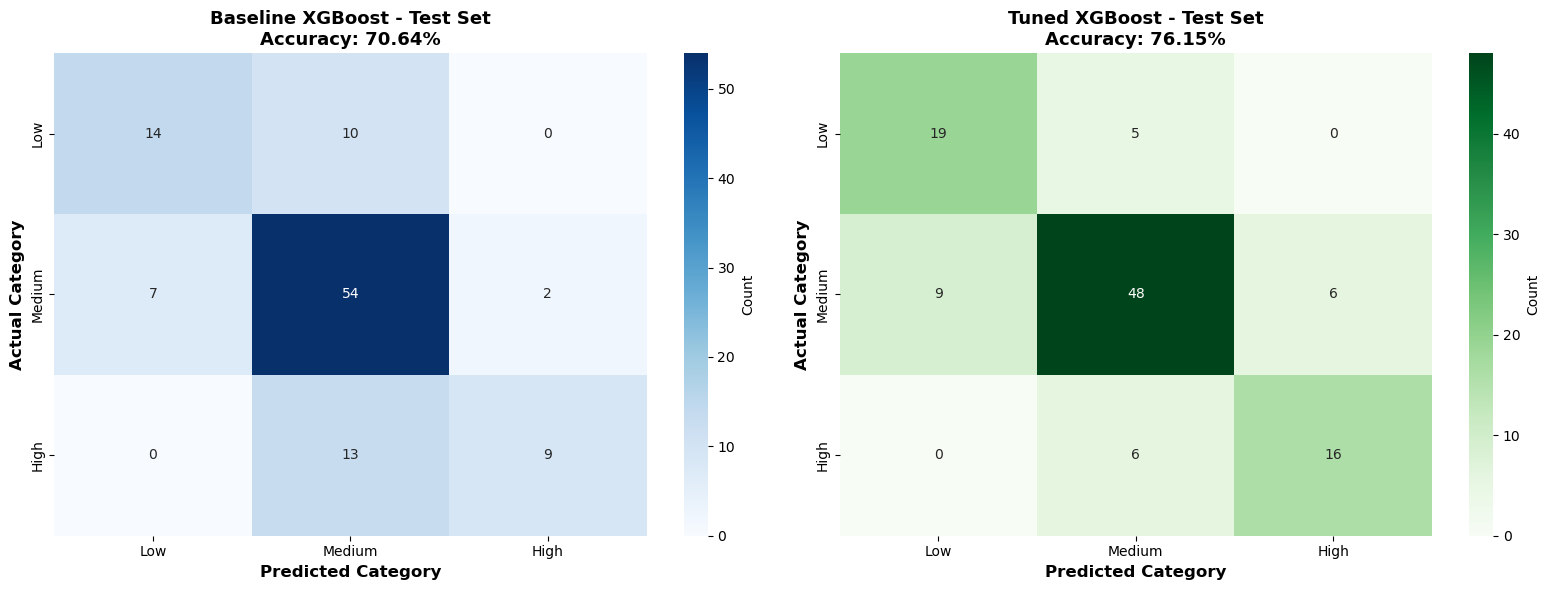


📊 CLASSIFICATION REPORTS

🔵 Baseline XGBoost:
              precision    recall  f1-score   support

         Low       0.67      0.58      0.62        24
      Medium       0.70      0.86      0.77        63
        High       0.82      0.41      0.55        22

    accuracy                           0.71       109
   macro avg       0.73      0.62      0.65       109
weighted avg       0.72      0.71      0.69       109


🟢 Tuned XGBoost:
              precision    recall  f1-score   support

         Low       0.68      0.79      0.73        24
      Medium       0.81      0.76      0.79        63
        High       0.73      0.73      0.73        22

    accuracy                           0.76       109
   macro avg       0.74      0.76      0.75       109
weighted avg       0.77      0.76      0.76       109



In [17]:
# Confusion matrices
cm_baseline = confusion_matrix(y_test_categorical, y_test_pred_baseline_cat, labels=['Low', 'Medium', 'High'])
cm_tuned = confusion_matrix(y_test_categorical, y_test_pred_tuned_cat, labels=['Low', 'Medium', 'High'])

# Side-by-side confusion matrix comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline confusion matrix
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'],
            cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Category', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Category', fontsize=12, fontweight='bold')
baseline_acc = np.trace(cm_baseline) / cm_baseline.sum() * 100
axes[0].set_title(f'Baseline XGBoost - Test Set\nAccuracy: {baseline_acc:.2f}%', 
                  fontsize=13, fontweight='bold')

# Tuned confusion matrix
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'],
            cbar_kws={'label': 'Count'})
axes[1].set_xlabel('Predicted Category', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Category', fontsize=12, fontweight='bold')
tuned_acc = np.trace(cm_tuned) / cm_tuned.sum() * 100
axes[1].set_title(f'Tuned XGBoost - Test Set\nAccuracy: {tuned_acc:.2f}%', 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 CLASSIFICATION REPORTS")
print("="*70)
print("\n🔵 Baseline XGBoost:")
print(classification_report(y_test_categorical, y_test_pred_baseline_cat, labels=['Low', 'Medium', 'High']))
print("\n🟢 Tuned XGBoost:")
print(classification_report(y_test_categorical, y_test_pred_tuned_cat, labels=['Low', 'Medium', 'High']))
print("="*70)


## 📊 Step 10: Final Summary & Conclusions


In [18]:
print("="*80)
print("🎯 FINAL SUMMARY - XGBOOST REGRESSION (NO PCA)")
print("="*80)
print(f"\n📊 Dataset:")
print(f"   Total compounds: {len(df_rdkit)}")
print(f"   Training set: {len(X_train)} (80%)")
print(f"   Test set: {len(X_test)} (20%)")
print(f"   Features: {X.shape[1]} RDKit descriptors (no PCA)")

print(f"\n🏆 Best Model Performance (Test Set):") 
print(f"   R² Score: {test_r2_tuned:.4f}")
print(f"   RMSE: {test_rmse_tuned:.4f}")
print(f"   MAE: {test_mae_tuned:.4f}")
print(f"   Classification Accuracy: {tuned_acc:.2f}%")

print(f"\n✨ Improvements from Tuning:")
print(f"   R² improvement: {r2_improvement:+.2f}%")
print(f"   RMSE improvement: {rmse_improvement:+.2f}%")
print(f"   MAE improvement: {mae_improvement:+.2f}%")

print(f"\n🔍 Top 3 Most Important Features:")
for i in range(min(3, len(feature_importance))):
    feat = feature_importance.iloc[i]
    print(f"   {i+1}. {feat['Feature']}: {feat['Importance']:.4f}")

print(f"\n💡 Key Insights:")
print(f"   • XGBoost with 80/20 split allows proper test set evaluation")
print(f"   • Early stopping prevents overfitting")
print(f"   • Hyperparameter tuning {'improved' if r2_improvement > 0 else 'maintained'} performance")
print(f"   • Model generalizes {'well' if overfit_r2_tuned < 0.05 else 'reasonably'} to unseen data")

print("\n" + "="*80)
print("✅ Analysis Complete!")
print("="*80)


🎯 FINAL SUMMARY - XGBOOST REGRESSION (NO PCA)

📊 Dataset:
   Total compounds: 541
   Training set: 432 (80%)
   Test set: 109 (20%)
   Features: 17 RDKit descriptors (no PCA)

🏆 Best Model Performance (Test Set):
   R² Score: 0.5797
   RMSE: 0.7381
   MAE: 0.5235
   Classification Accuracy: 76.15%

✨ Improvements from Tuning:
   R² improvement: -0.56%
   RMSE improvement: -0.39%
   MAE improvement: +4.66%

🔍 Top 3 Most Important Features:
   1. NumRings: 0.3470
   2. NumAliphaticRings: 0.1547
   3. NumSaturatedRings: 0.1345

💡 Key Insights:
   • XGBoost with 80/20 split allows proper test set evaluation
   • Early stopping prevents overfitting
   • Hyperparameter tuning maintained performance
   • Model generalizes reasonably to unseen data

✅ Analysis Complete!


In [19]:
# Save XGBoost model and scaler
import os, joblib
os.makedirs('saved_models', exist_ok=True)

joblib.dump(best_xgb_model, 'saved_models/xgb_model.pkl')
joblib.dump(scaler, 'saved_models/xgb_scaler.pkl')
print("✅ Saved XGB model & scaler to saved_models/")

✅ Saved XGB model & scaler to saved_models/
